In [1]:
from numpy.random.bit_generator import SeedlessSeedSequence
import tensorflow as tf
import os
import numpy as np
import random
from sklearn.utils import shuffle
#from tqdm import tqdm #Provides a progress bar while the images are being resized
from skimage.io import imshow, imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tifffile as tiff 
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score,  accuracy_score, f1_score, make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import random
#%load_ext tensorboard
from keras import backend as K
seed =42
np.random.seed=42
from spectral import *

ModuleNotFoundError: No module named 'keras.utils.vis_utils'

In [85]:
HEIGHT = 512
WIDTH = 512
CHANNELS = 9

In [106]:
X=[]
y=[]

for a in range(5,11):
  Xpath = '/Users/anshugusain/tf-nuclei/content/Stained-40X/Field' + str(a) + '/cube_envi32.hdr'
  Ximg = spectral.open_image(Xpath)


  Field = Ximg.read_bands((51,52,53,90,91,92,130,131,132)) #9 bands
  #Field = Ximg.read_bands((52,53,91,92,131)) #5 bands
  #Field = Ximg.read_bands((37,77,127))
  
  ypath = '/Users/anshugusain/tf-nuclei/content/Stained-40X/Field' + str(a) + '/Field' + str(a) + '-mask.tif'
  yimg = tf.keras.preprocessing.image.load_img(ypath, grayscale=True)
    

  Xpatches = patchify(Field,(HEIGHT,WIDTH,CHANNELS),step=HEIGHT)

  yimg = np.asarray(yimg)>0
  ypatches = patchify(yimg, (HEIGHT,WIDTH), step=HEIGHT)

  for m in range(0, Xpatches.shape[0]):
    for l in range(0, Xpatches.shape[1]):
      X.append(Xpatches[m,l,0])
      y.append(ypatches[m,l])

/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [107]:
X = np.array(X)
y = np.array(y)

In [108]:
X = (X/X.max())
y = (y/y.max())

In [109]:
X.shape

(6, 512, 512, 9)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=42, test_size=0.20, shuffle=True)
y_train = y_train.astype(X_train.dtype)

In [111]:
X_train.shape

(4, 512, 512, 9)

In [112]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

In [113]:
#Building the model

inputs = tf.keras.layers.Input((HEIGHT, WIDTH, CHANNELS))
s = inputs #converts integers from input layers into floating points

#Contraction Path
                           # feature space  
                           # \/
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = "relu", kernel_initializer='he_normal', padding = 'same')(s)#kernel initializer is the initial weights used by the neural network (he_normal is a trunkated normal distribution centered on 0)
c1 = tf.keras.layers.Dropout(.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = "relu", kernel_initializer="he_normal", padding = "same")(c1 ) #Padding ensures that the output image has the same dimensions as the input image
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1) #First maxpooling layer puts the values into a 2x2 matrix, and gets the maximum values

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = tf.keras.layers.Dropout(.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3= tf.keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = tf.keras.layers.Dropout(.2)(c3)
c3=tf.keras.layers.Conv2D(64,(3,3), activation = "relu", kernel_initializer="he_normal", padding="same")(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4= tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4= tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5=tf.keras.layers.Conv2D(256, (3,3), activation ="relu", kernel_initializer="he_normal", padding="same")(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)


u9= tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
u9= tf.keras.layers.concatenate([u9,c4])#Concatenates layers u6 and c4 as shown in the Unet architecture
c9=tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding="same")(u9)
c9=tf.keras.layers.Dropout(0.2)(c9)
c9=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

u10= tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c9)
u10= tf.keras.layers.concatenate([u10,c3])#Concatenates layers u6 and c4 as shown in the Unet architecture
c10=tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding="same")(u10)
c10=tf.keras.layers.Dropout(0.2)(c10)
c10=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

u11=tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c10)
u11=tf.keras.layers.concatenate([u11,c2])
c11=tf.keras.layers.Conv2D(32,(3,3), activation="relu",kernel_initializer="he_normal", padding="same")(u11)
c11=tf.keras.layers.Dropout(0.2)(c11)
c11=tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c11)

u12=tf.keras.layers.Conv2DTranspose(16, (2,2),strides=(2,2), padding="same")(c11)
u12=tf.keras.layers.concatenate([u12, c1])
c12=tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u12)
c12=tf.keras.layers.Dropout(0.1)(c12)
c12=tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c12)

outputs=tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid")(c12)
model=tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=.001), loss=jacard_coef_loss, metrics=jacard_coef)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 9  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 512, 512, 16  1312        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_45 (Dropout)           (None, 512, 512, 16  0           ['conv2d_95[0][0]']              
                                )                                                           

/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [114]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [115]:
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

((4, 512, 512, 9), (4, 512, 512), dtype('float32'), dtype('float32'))

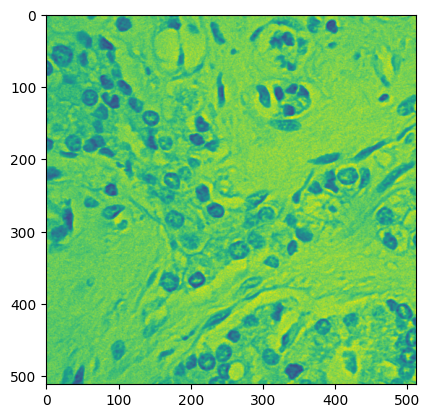

In [116]:
plt.imshow(X_train[0][:,:,-1])

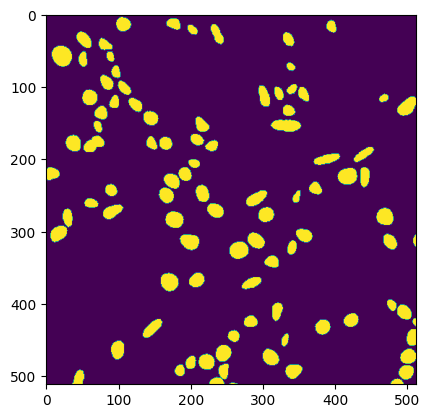

In [117]:
plt.imshow(y_train[0])

In [118]:
filepath="/Users/anshugusain/tf-nuclei/Models/new_spectral-bestVAL/best_weights.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_jacard_coef', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

results = model.fit(X_train, y_train, batch_size = 1, epochs=100, shuffle=True, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/100


2023-11-10 10:00:31.358842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x512x512x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x256x256x32x

1/4 [======>.......................] - ETA: 6s - loss: -0.1268 - jacard_coef: 0.1268

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x256x256x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x512x512x16xi1>'


4/4 [==============================] - ETA: 0s - loss: -0.1317 - jacard_coef: 0.1317

2023-11-10 10:00:33.558636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_jacard_coef improved from -inf to 0.12825, saving model to /Users/anshugusain/tf-nuclei/Models/new_spectral-bestVAL/best_weights.h5
4/4 [==============================] - 3s 330ms/step - loss: -0.1317 - jacard_coef: 0.1317 - val_loss: -0.1282 - val_jacard_coef: 0.1282
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: -0.1998 - jacard_coef: 0.1998
Epoch 2: val_jacard_coef improved from 0.12825 to 0.14932, saving model to /Users/anshugusain/tf-nuclei/Models/new_spectral-bestVAL/best_weights.h5
4/4 [==============================] - 1s 210ms/step - loss: -0.1998 - jacard_coef: 0.1998 - val_loss: -0.1493 - val_jacard_coef: 0.1493
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: -0.3027 - jacard_coef: 0.3027
Epoch 3: val_jacard_coef did not improve from 0.14932
4/4 [==============================] - 0s 113ms/step - loss: -0.3027 - jacard_coef: 0.3027 - val_loss: -0.1005 - val_jacard_coef: 0.1005
Epoch 4/100
4/4 [==============================

In [119]:
#model = tf.keras.models.load_model('/Users/anshugusain/tf-nuclei/Models/new_spectral-bestVAL/best_weights.h5')
model = tf.keras.models.load_model('/Users/anshugusain/tf-nuclei/Models/new_spectral-bestVAL/best_weights.h5', custom_objects={'jacard_coef_loss': jacard_coef_loss,'jacard_coef':jacard_coef})
#model = tf.keras.models.load_model('/Users/anshugusain/tf-nuclei/Models/new_spectral-bestVAL/best_weights-max86x5Bands.h5', custom_objects={'jacard_coef_loss': jacard_coef_loss,'jacard_coef':jacard_coef})

In [120]:
def average_calc(X_examine, y_examine):
  IoUs = [len(X_examine)]
  total =0
  average =0

  for i in range(0,len(X_examine)):
    test_predict = model.predict(np.expand_dims(X_examine[i],0))
    test_predict = np.asarray(test_predict) 
    IoU = jaccard_score((test_predict>0.95).squeeze(), (y_examine[i]>0.7).squeeze(), average='micro')
    total =IoU + total
  average = total / len(X_examine)
  
  return average

def average_Fscore(X_examine, y_examine):
  IoUs = [len(X_examine)]
  total =0
  average =0

  for i in range(0,len(X_examine)):
    test_predict = model.predict(np.expand_dims(X_examine[i],0))
    test_predict = np.asarray(test_predict) 
    IoU = f1_score((test_predict>0.99).squeeze(), (y_examine[i]).squeeze(), average='micro')
    total =IoU + total
  average = total / len(X_examine)
  
  return average

In [121]:
average_calc(X_test, y_test)

2023-11-10 10:01:09.722191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 21ms/step


0.5488714048466887

In [102]:
average_Fscore(X_test, y_test)

1/1 [==============================] - 0s 38ms/step


0.8184404311003463

In [20]:
model.evaluate(X_test, y_test)

2023-11-09 21:35:40.585571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 575ms/step - loss: -0.6860 - jacard_coef: 0.6860


[-0.6860087513923645, 0.6860087513923645]

In [24]:
model.save('/Users/anshugusain/tf-nuclei/Models/new_spectral-bestVAL/best_weights-max6x3Bands.h5')

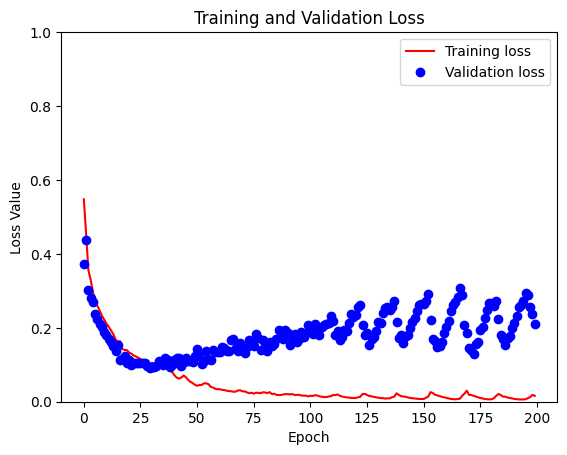

In [34]:
loss = results.history['loss']
val_loss = results.history['val_loss']

plt.figure()
plt.plot(results.epoch, loss, 'r', label='Training loss')
plt.plot(results.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [122]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [123]:
image_num = int(random.random()*len(X_test))
test_predict = model.predict(np.expand_dims(X_test[image_num],0))
test_predict = np.asarray(test_predict)

1/1 [==============================] - 0s 71ms/step


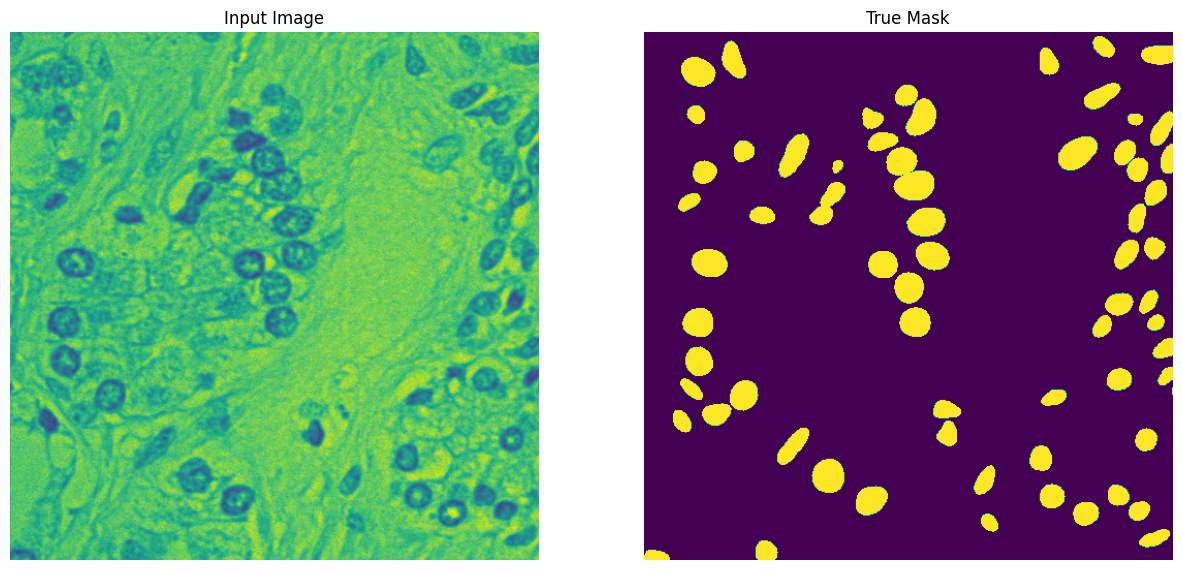

In [124]:
display((X_test[image_num][:,:,-2],y_test[image_num]))

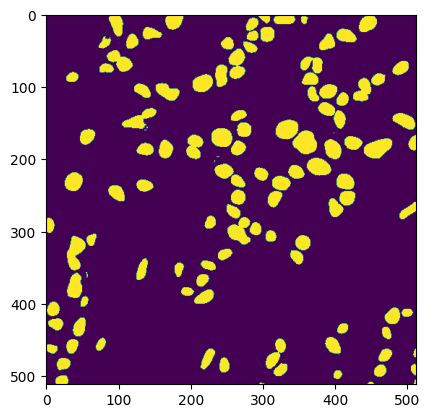

In [18]:
plt.imshow(test_predict.squeeze()>.3)

In [129]:
def show_predictions(dataset=None, num=1):
    test_predict = model.predict(np.expand_dims(X_test[num],0))
    test_predict = np.asarray(test_predict)
    display([X_test[num][:,:,-1], y_test[num], (test_predict.squeeze())>.99])
    

1/1 [==============================] - 0s 22ms/step


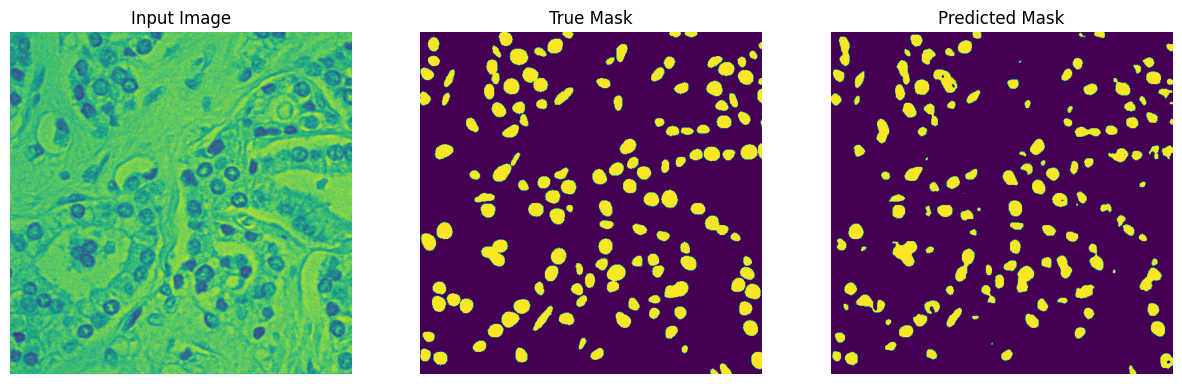

In [130]:
show_predictions(X_test ,0)


<Figure size 700x350 with 0 Axes>

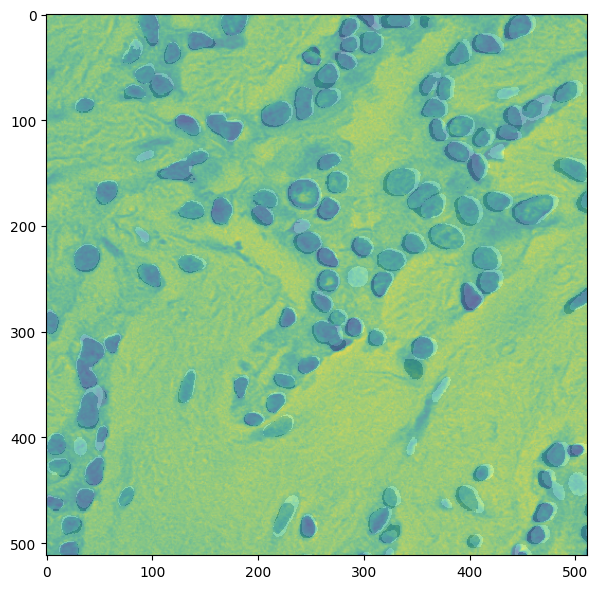

In [28]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
mask = test_predict.squeeze()>0.95
im = y_test[image_num]
masked = np.ma.masked_where(mask == 0, mask)
plt.figure()
#plt.subplot(1, 2, 1)
#plt.imshow(im, 'gray', interpolation='none')
#plt.subplot(1, 2, 2)
plt.figure(figsize=(10,6))
plt.imshow(im, 'gray', interpolation='none', alpha = .4)
plt.imshow(mask,"Blues", interpolation='none', alpha=.4)
plt.imshow(X_test[image_num][:,:,-1], alpha = .6)

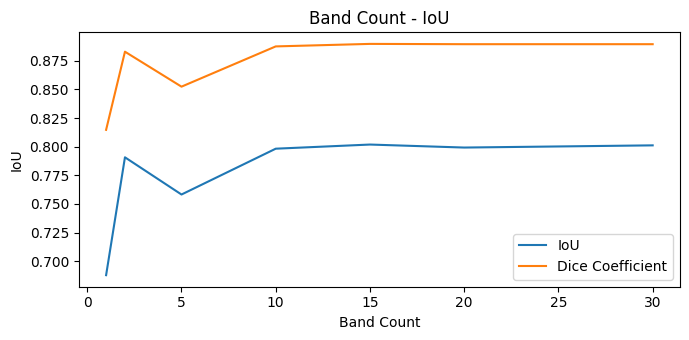

In [22]:
x = [1,2,5,10,15,20,30]
# corresponding y axis values
y1 = [0.687831400939273,0.7907462035824222,0.7582585401,0.7982714582,0.8018897745,0.7992674893,0.8011837418]
y2 = [0.8147275405851667,0.8829768485652738,0.8524437351,0.8875934249,0.8897860473,0.8895282768,0.8895282768]
  
# plotting the points 
plt.plot(x, y1, label = "IoU")
plt.plot(x, y2, label = "Dice Coefficient")
  
plt.legend()
# naming the x axis
plt.xlabel('Band Count')
# naming the y axis
plt.ylabel('IoU')
  
# giving a title to my graph
plt.title('Band Count - IoU')
  
# function to show the plot
plt.show()

/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


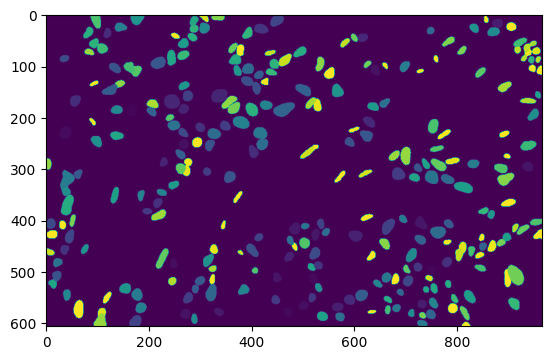

In [4]:
Xpath = '/Users/anshugusain/tf-nuclei/content/Stained-40X/Field1/Field1-mask.tif'
Xpath = tf.keras.preprocessing.image.load_img(Xpath, grayscale=True)
plt.imshow(Xpath)

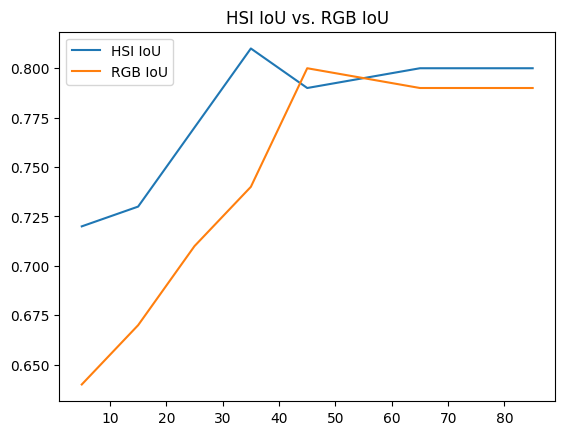

In [83]:

import matplotlib.pyplot as plt 
  
# create data 
x = [5,15,25,35,45,65,85] 

y_spectral = [.72,.73,.77,.81,.79,.80,.80] 
y_RGB = [.64,.67,.71,.74,.80,.79,.79]
  
# plot lines 
plt.title("HSI IoU vs. RGB IoU")
plt.plot(x, y_spectral, label = "HSI IoU") 
plt.plot(x, y_RGB, label = "RGB IoU") 
plt.legend() 
plt.show()